# ----------------------- Final Year Project -----------------------
# Title : Automatic Number Plate Recognition using using Contours and Convolution Neural Networks (CNN)

## Paper publication: https://www.ijariit.com/manuscripts/v7i4/V7I4-1139.pdf

### By Adithya M, Rahul K, Nitish Kumar P, Pramod G N

### Guided by Mrs Sumitha B S



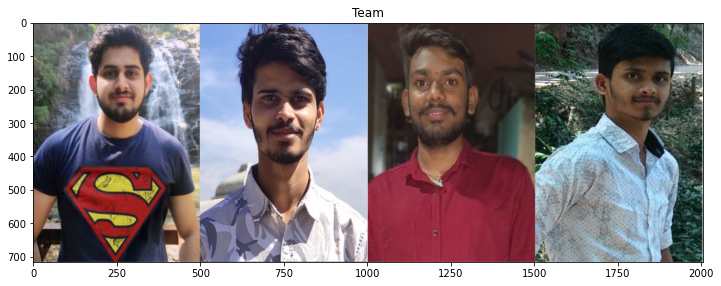

In [27]:
image = cv2.imread('team.png')
plt.figure(figsize=(12,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.title('Team')
plt.show()

# Automatic Number Plate Recognition using using Contours and Convolution Neural Networks (CNN)
#### In this project notebook, we show the overall implementation of License Plate Detection using the Contour method.

The contours are a useful tool for shape analysis and object detection and recognition. Using contour detection, we can detect the borders of objects, and therefore, localize them easily. Importantly, contour detection could be the very first step for many interesting applications such as image foreground extraction, simple image segmentation, detection and recognition.

## Import the necessary libraries

In [28]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers


from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [29]:
pwd

'C:\\Users\\adith\\License-Plate-Number-Detection'

## Load the image
In this step, we load an image that contains a car with its license plate.

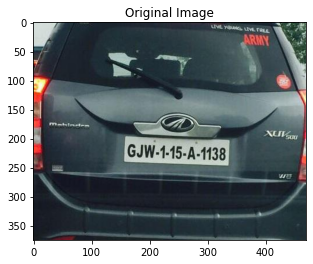

In [30]:
# Read the image file
image = cv2.imread('test_dataset/images/2.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

## Finding Contours
In this, the image is first preprocessed and then sent for finding contours.
Image preprocessing contains the following steps:
- **Resizing the image**
- **Grayscale Conversion**
- **Noise Removal**
- **Binarization**

After this, the image is ready to find contours.


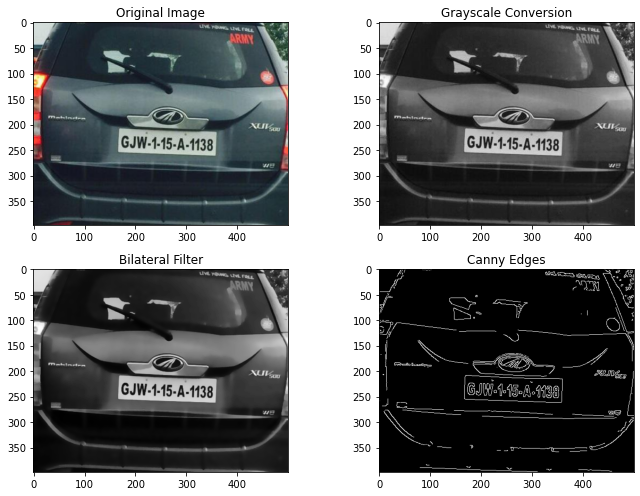

In [31]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

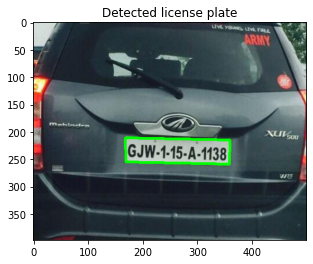

In [32]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

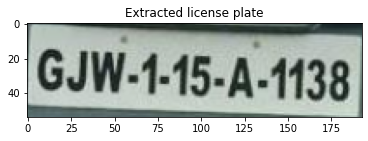

In [33]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

## Rotate the plate (if tilted)
This step is useful if the extracted license plate is tilted/rotated. It might arise problems in the character segmentation phase, so it is better to straighten it.

In [34]:
print(NumberPlateCnt)

[[[168 211]]

 [[169 255]]

 [[358 259]]

 [[359 215]]]


In [35]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [36]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

1 2


Extract the coordinates of the bottom-most coordinates in such a way that ```(left_x, left_y)``` denote the bottom-left coordinate and ```(right_x, right_y)``` denote the bottom-right coordinate.

In [37]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

169 255 358 259


For rotating the plate, we need to find the angle of rotation. This can be found out by calculating the sin of theta using the two coordinates. Theta can then be extracted by finding the inverse of sin. Image can finally be rotated by using ```cv2.getRotationMatrix2D()``` function.

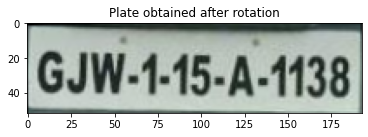

In [38]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition.



In [39]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [40]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

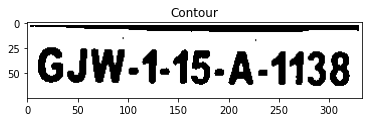

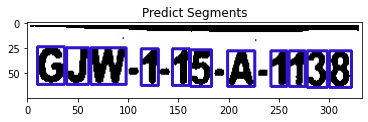

In [41]:
char=segment_characters(result)

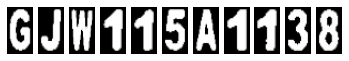

In [42]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN
Since the data is all clean and ready, now it’s time do create a Neural Network that will be intelligent enough to recognize the characters after training. In this project, we used CNN model for character recognition.


In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [44]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics='accuracy')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [19]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 21s 23ms/step - loss: 3.0717 - accuracy: 0.1562 - val_loss: 1.8651 - val_accuracy: 0.4398
Epoch 2/25
864/864 [==============================] - 21s 25ms/step - loss: 1.4200 - accuracy: 0.5613 - val_loss: 0.9471 - val_accuracy: 0.6759
Epoch 3/25
864/864 [==============================] - 22s 26ms/step - loss: 0.7325 - accuracy: 0.7500 - val_loss: 0.6276 - val_accuracy: 0.7870
Epoch 4/25
864/864 [==============================] - 21s 25ms/step - loss: 0.4707 - accuracy: 0.8472 - val_loss: 0.3311 - val_accuracy: 0.8750
Epoch 5/25
864/864 [==============================] - 21s 25ms/step - loss: 0.3409 - accuracy: 0.8935 - val_loss: 0.1921 - val_accuracy: 0.9491
Epoch 6/25
864/864 [==============================] - 21s 25ms/step - loss: 0.2476 - accuracy: 0.9190 - val_loss: 0.3333 - val_accuracy: 0.8935
Epoch 7/25
864/864 [==============================] - 23s 26ms/step - loss: 0.2301 - accuracy: 0.9294 - val_loss: 0.2046 - val_accuracy:

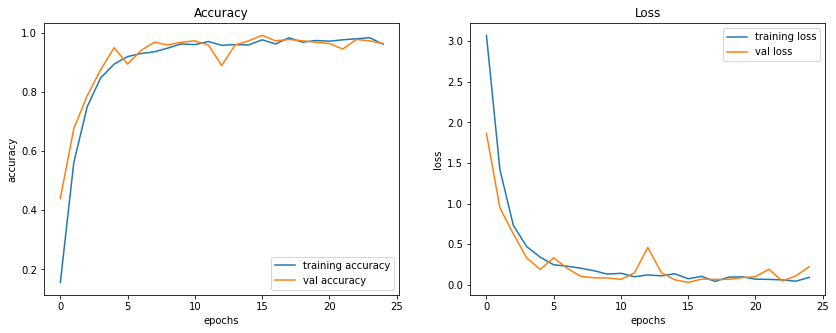

In [20]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [21]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

In [45]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Predict the license plate number


In [46]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results(count):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results(count))

GJW115A1138


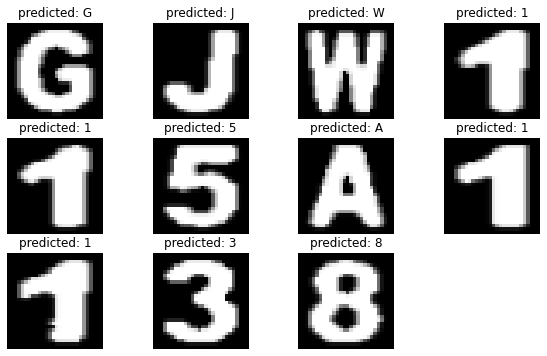

In [47]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(count)[i]}')
    plt.axis('off')
#plt.show(count)

## Accuracy
We now need to run the whole code for all the images and calculate the accuracy.

In [25]:
pwd

'C:\\Users\\adith\\License-Plate-Number-Detection'

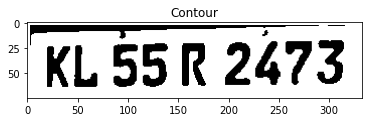

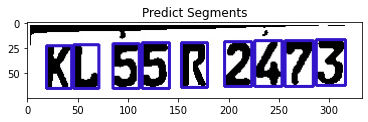

KL55R2473
1.jpg


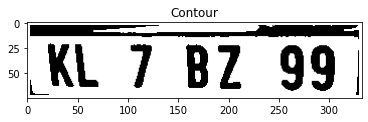

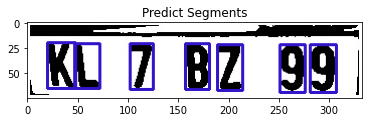

IL7BI99
10.jpg


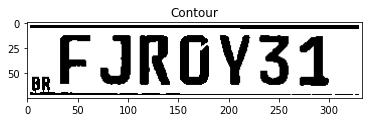

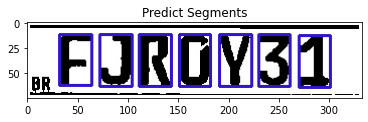

FJR0Y51
100.JPG


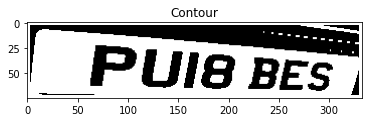

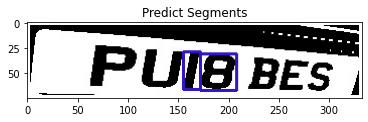

J8
101.png


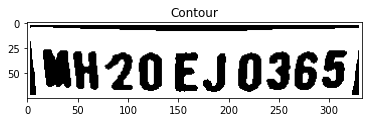

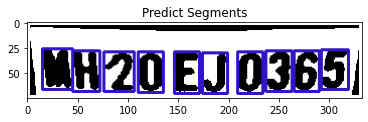

IM20EJ0J65
102.jpeg


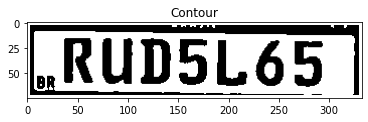

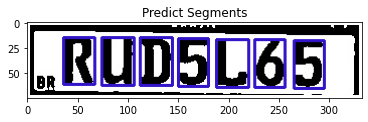

RUJ5L65
103.JPG


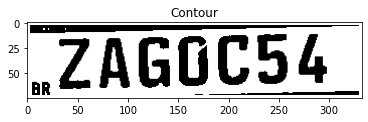

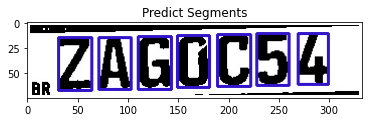

ZA60C54
104.JPG


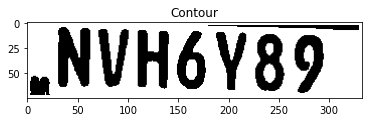

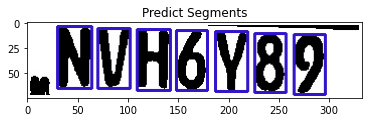

NVN6Y89
105.JPG


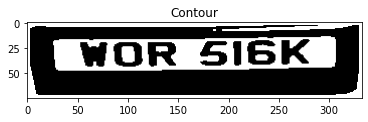


106.png


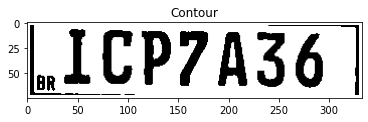

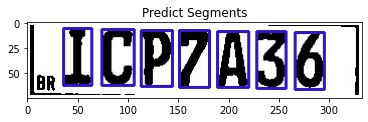

ICP7A56
108.JPG


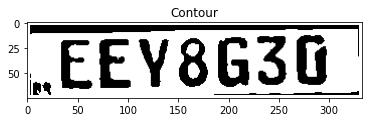

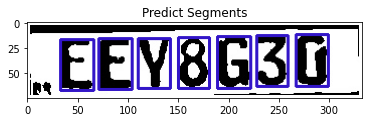

EEY6650
109.JPG


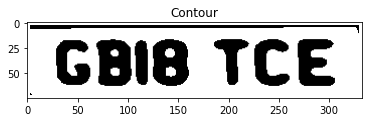

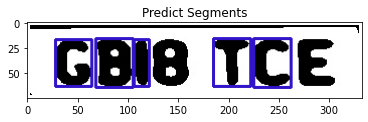

GJJTC
11.png


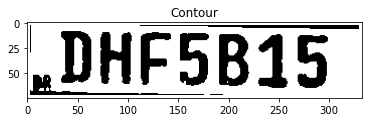

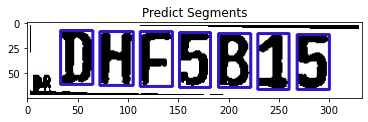

JNF5815
110.JPG


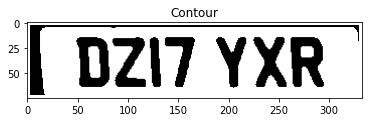

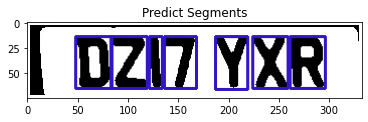

DIJ7YXR
111.png


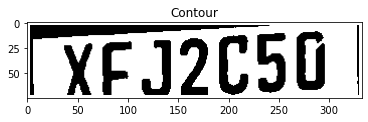

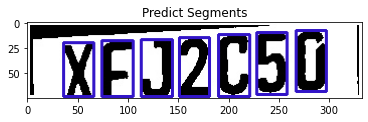

XFJ2C50
112.JPG


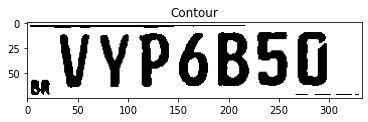

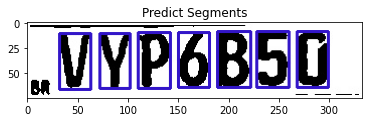

VYP6850
113.JPG


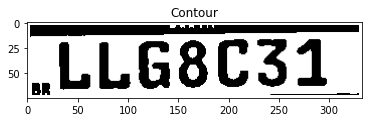

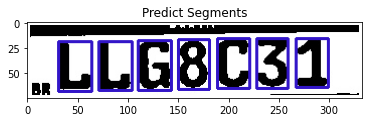

LL68C51
114.JPG


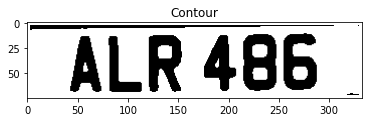

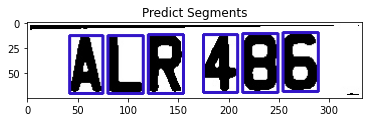

ALR486
115.png


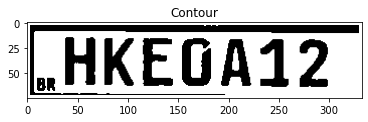

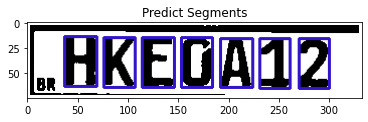

NKE0A12
116.JPG


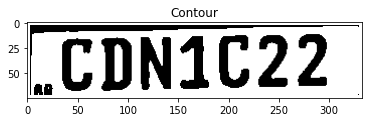

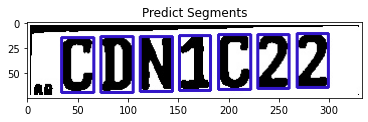

CJN1C22
117.JPG


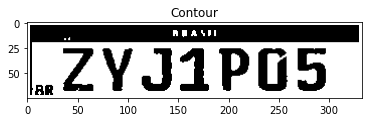

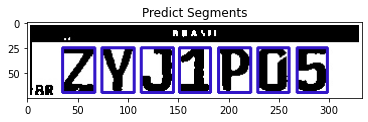

ZYJ1P05
118.JPG


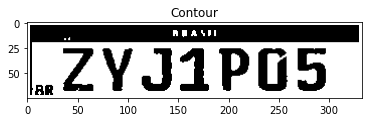

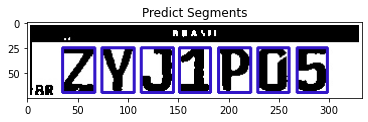

ZYJ1P05
119.JPG


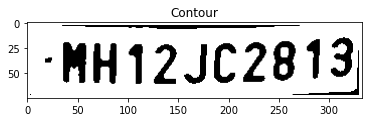

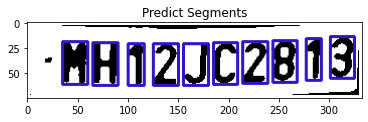

WH12JC28T3
12.jpg


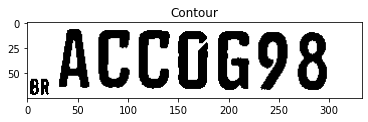

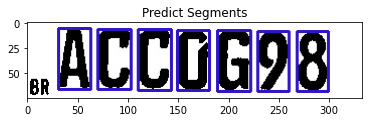

ACC0G98
120.JPG


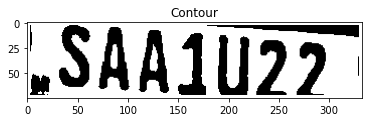

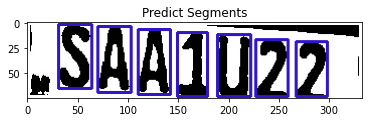

5AAJU22
121.JPG


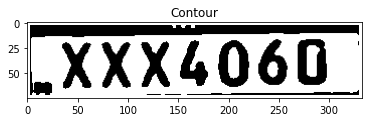

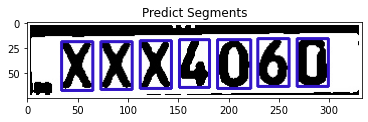

XXX4060
122.JPG


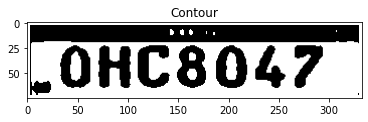

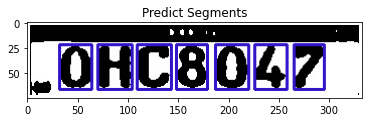

0NC8047
123.JPG


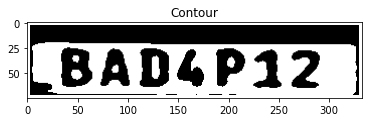

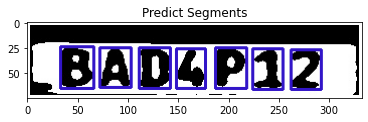

6AJ4PJ2
125.JPG


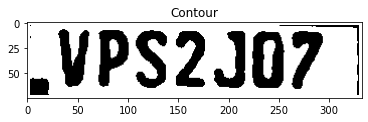

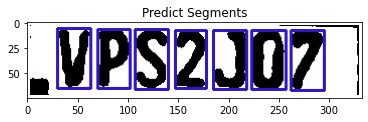

YP52J07
126.JPG


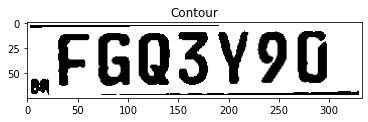

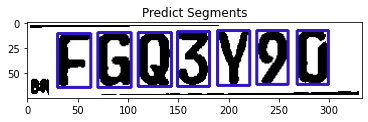

F6Q5Y90
127.JPG


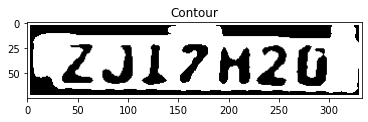

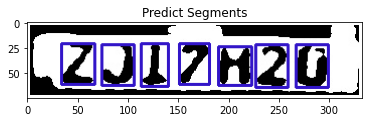

ZJ17N20
128.JPG


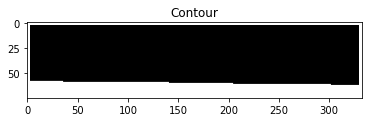


129.png


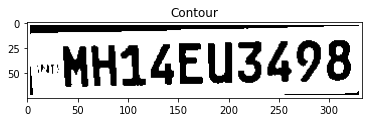

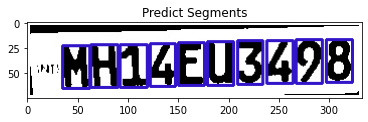

MM14EU3498
13.jpg


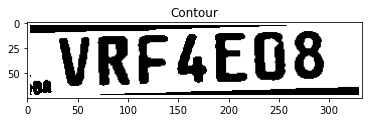

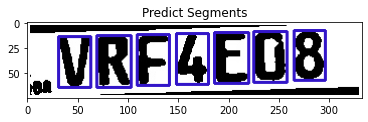

VRF4E06
130.JPG


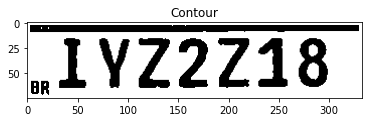

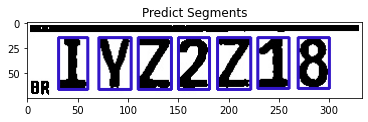

IYZ2Z18
131.JPG


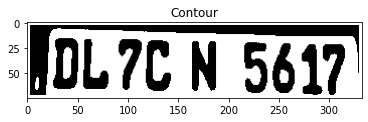

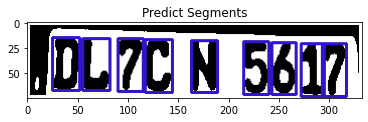

JL7CN56I7
133.png


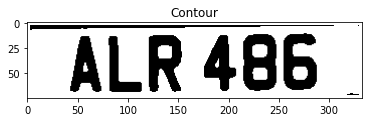

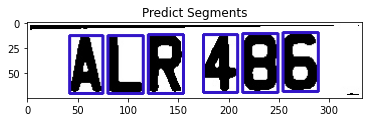

ALR486
134.png


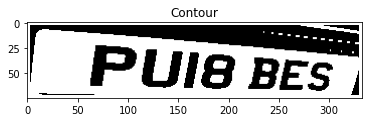

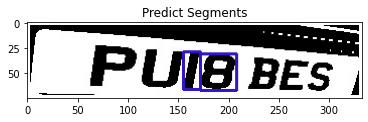

J8
135.png


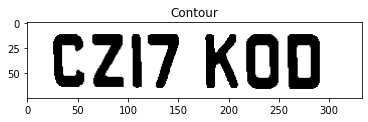

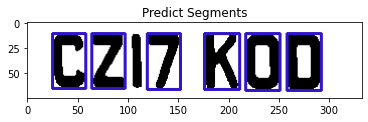

CI7K00
137.png


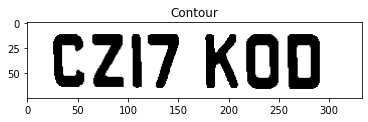

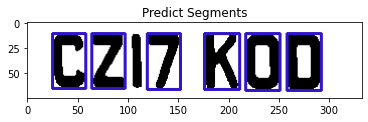

CI7K00
138.png


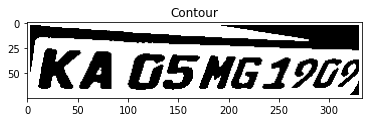

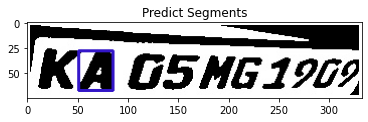

A
139.png


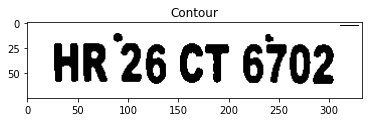

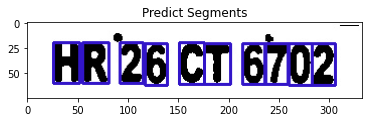

MR26CT6702
14.jpg


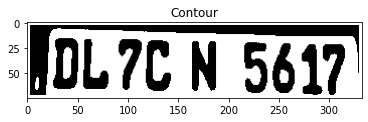

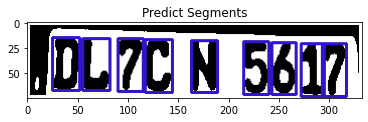

JL7CN56I7
140.png


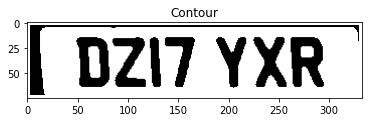

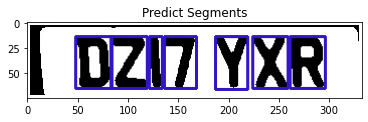

DIJ7YXR
141.png


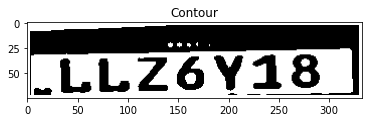

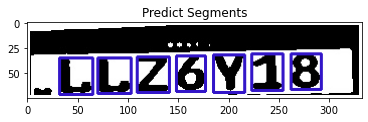

LLZ6Y18
143.JPG


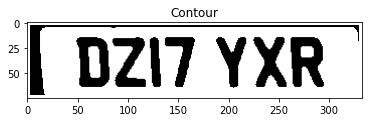

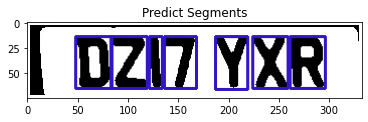

DIJ7YXR
144.png


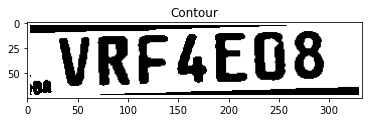

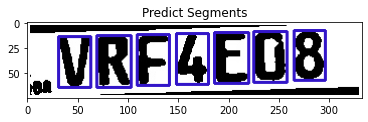

VRF4E06
146.JPG


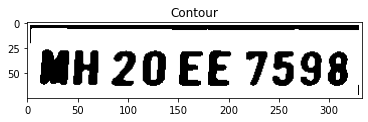

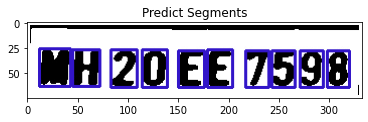

IW20EE7598
148.png


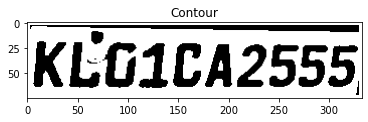

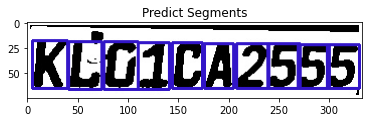

XEGICA2555
149.png


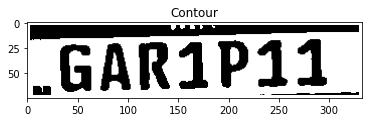

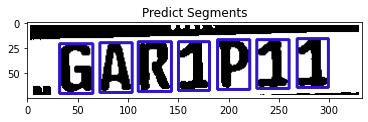

6AR1P11
15.JPG


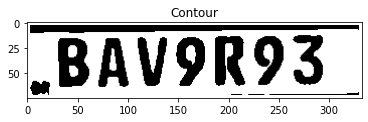

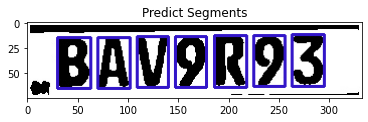

BAV9R95
150.JPG


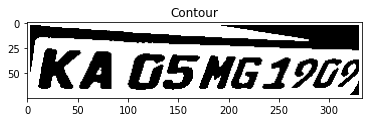

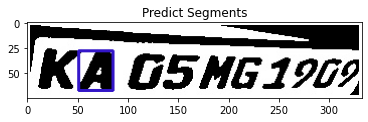

A
151.png


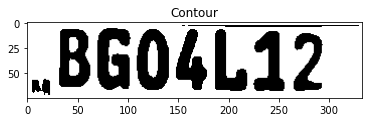

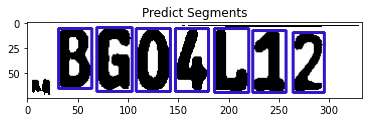

8604L12
152.JPG


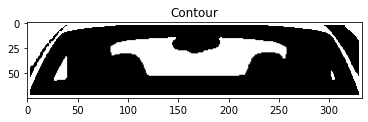

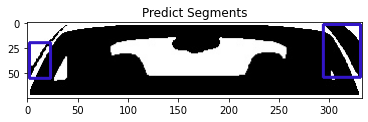

49
153.png


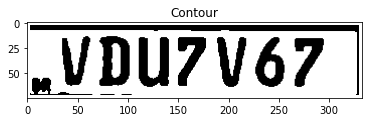

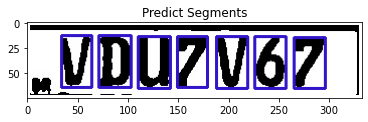

VJU7V67
154.JPG


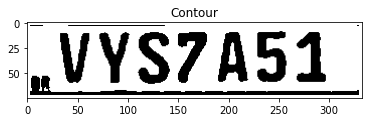

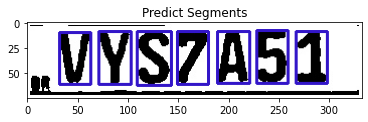

VY57A51
156.JPG


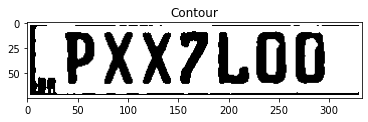

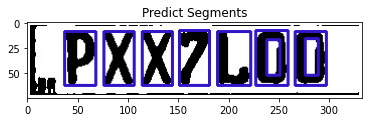

PXX7L0J0J
157.JPG


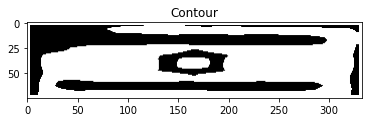


158.png


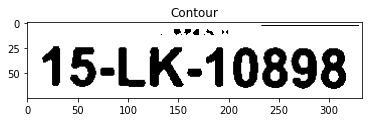

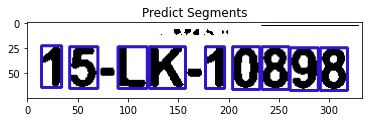

15LK10898
159.png


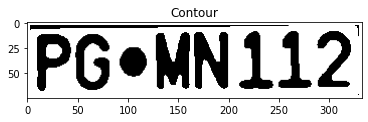

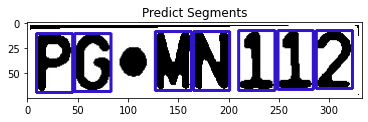

P6MN112
16.png


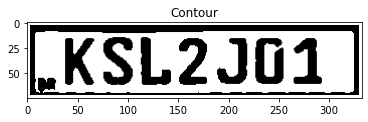

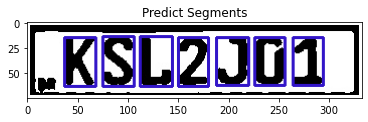

K5L2J01
160.JPG


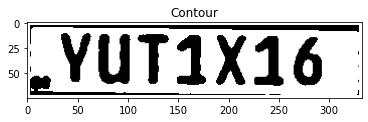

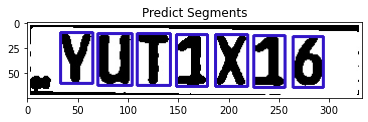

YUT1X16
161.JPG


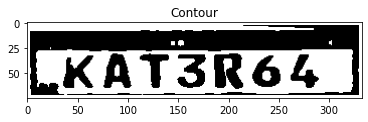

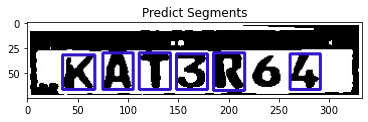

KAT3R4
162.JPG


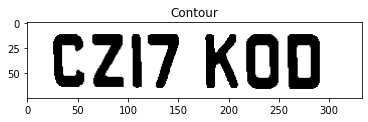

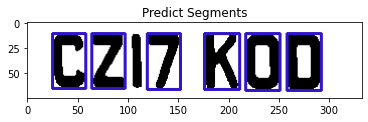

CI7K00
163.png


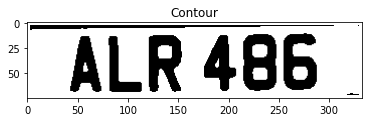

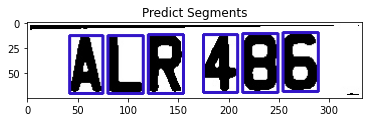

ALR486
164.png


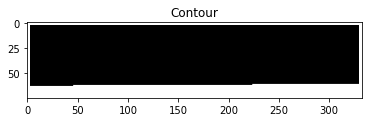


166.png


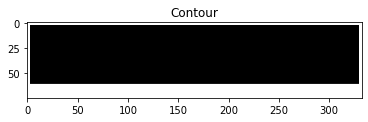


167.png


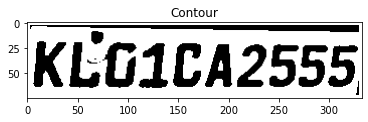

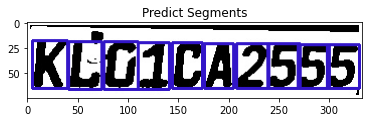

XEGICA2555
168.png


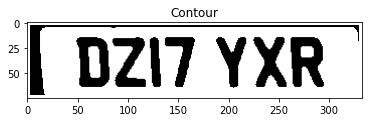

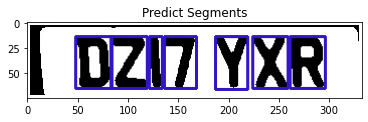

DIJ7YXR
17.png


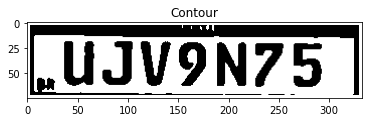

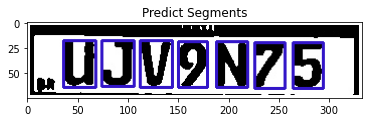

UJV9N75
170.JPG


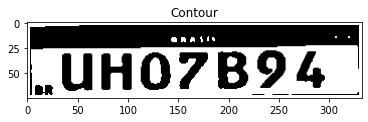

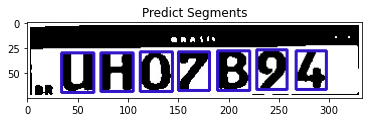

UH07894
171.JPG


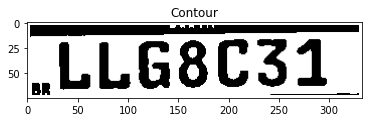

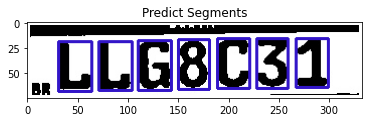

LL68C51
172.JPG


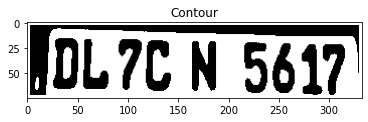

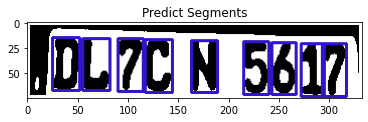

JL7CN56I7
173.png


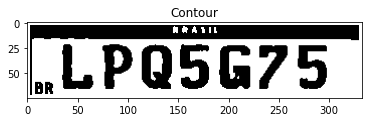

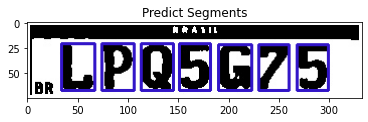

LPQ5G75
174.JPG


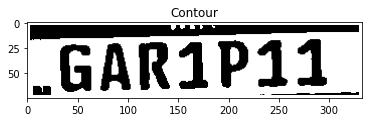

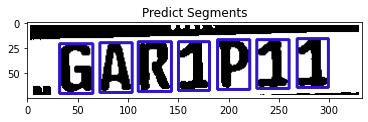

6AR1P11
175.JPG


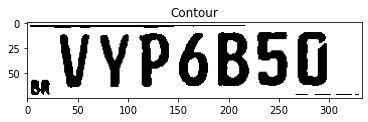

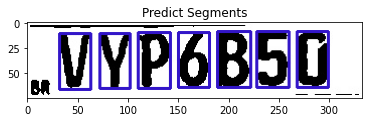

VYP6850
176.JPG


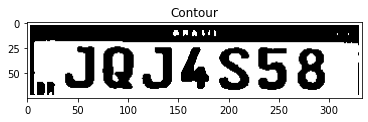

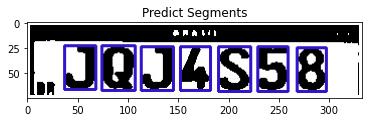

JQJ4558
177.JPG


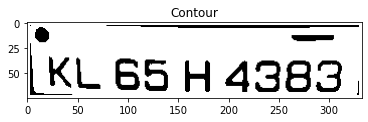


178.png


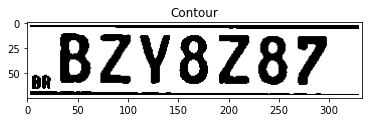

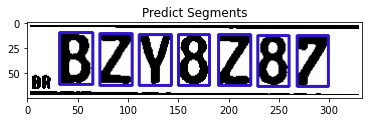

8ZY8Z67
179.JPG


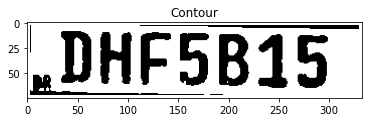

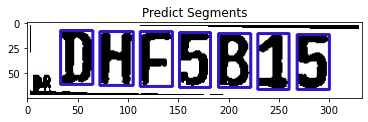

JNF5815
182.JPG


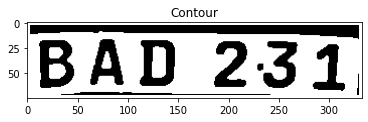

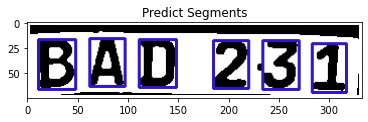

6AD231
185.png


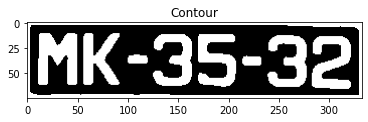

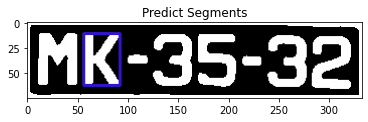

G
186.png


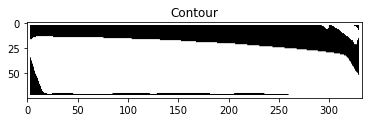


188.png


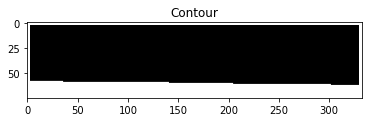


189.png


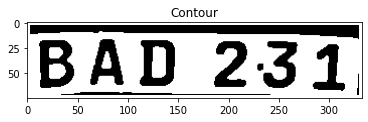

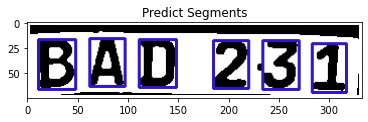

6AD231
19.png


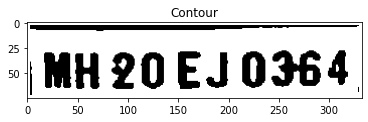

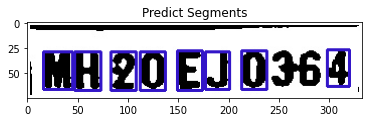

IN20EJ04
190.jpeg


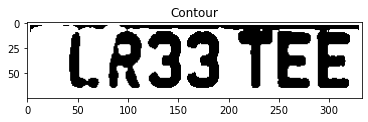

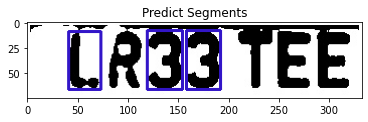

L33
193.png


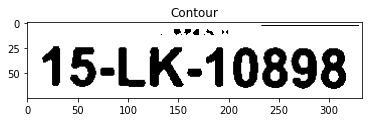

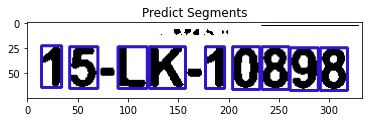

15LK10898
194.png


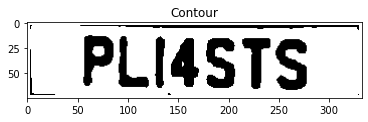

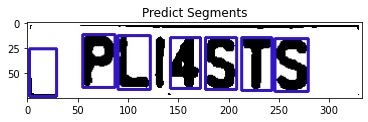

LPL45T5
195.jpeg


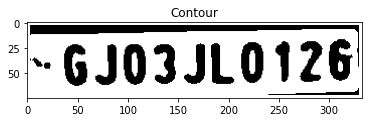

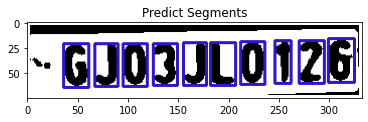

GJ0JJL0J26
197.png


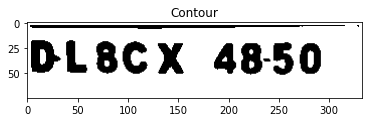

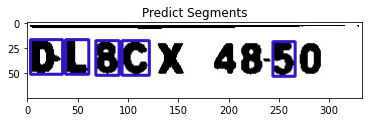

6LJC5
199.png


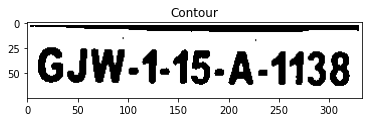

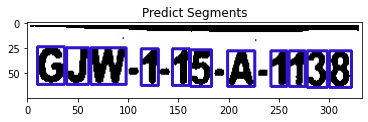

GJW115A1138
2.jpg


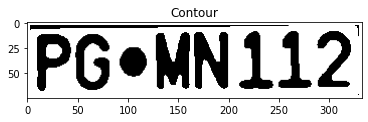

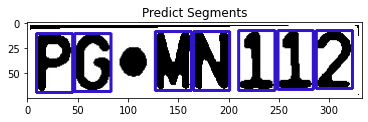

P6MN112
20.png


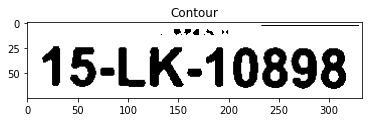

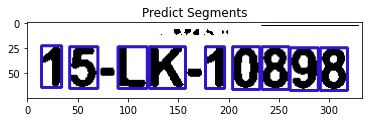

15LK10898
21.png


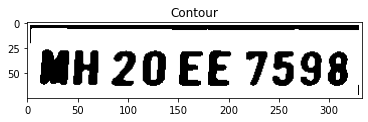

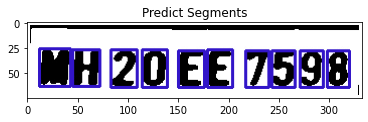

IW20EE7598
22.png


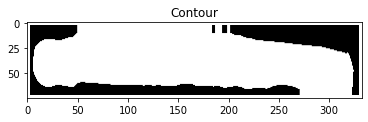


23.png


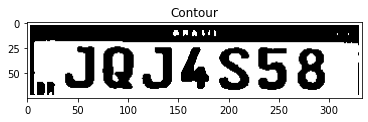

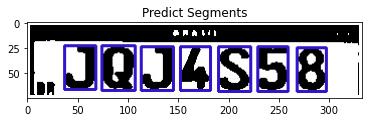

JQJ4558
24.JPG


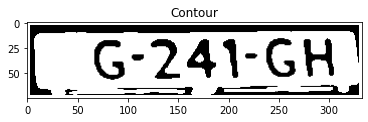

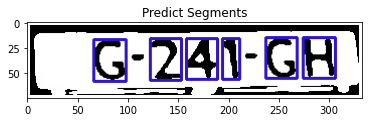

G241GH
25.jpg


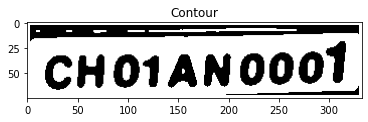

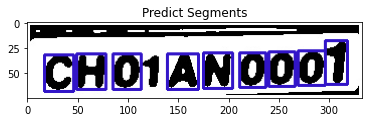

CN0AW000J
26.png


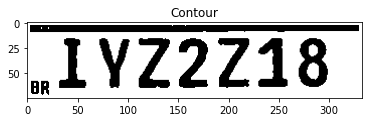

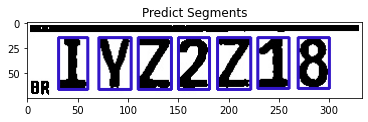

IYZ2Z18
27.JPG


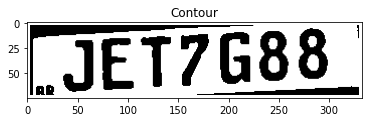

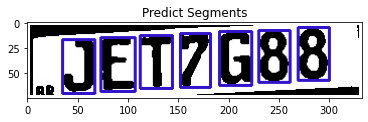

JET7666
28.JPG


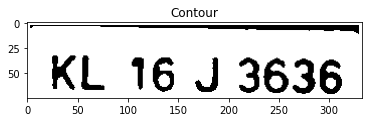

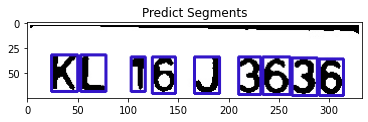

KL16J3636
3.jpg


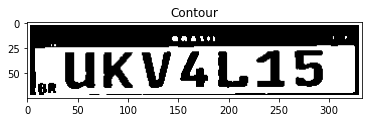

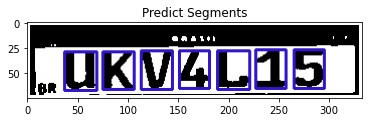

UKV4L15
30.JPG


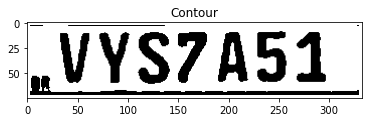

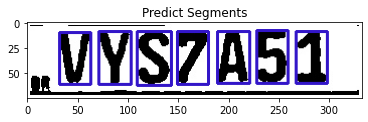

VY57A51
31.JPG


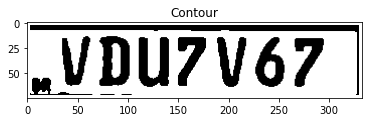

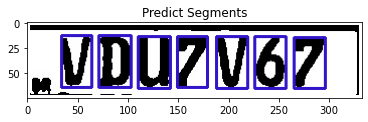

VJU7V67
32.JPG


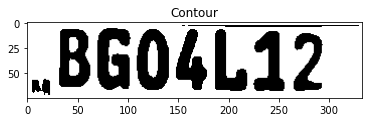

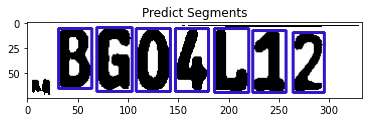

8604L12
33.JPG


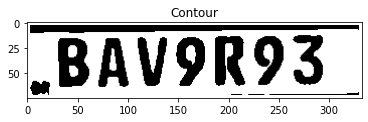

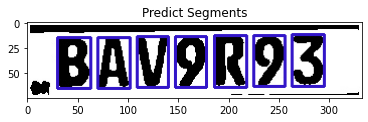

BAV9R95
34.JPG


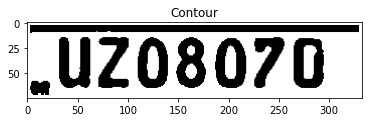

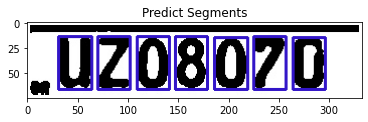

UZ08070
35.JPG


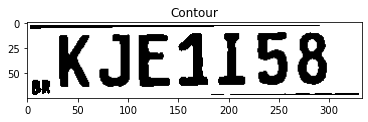

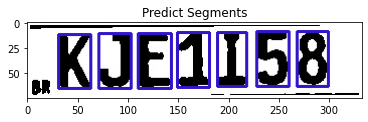

KJE1I58
36.JPG


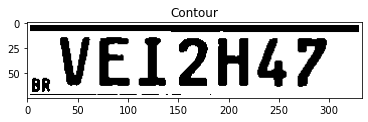

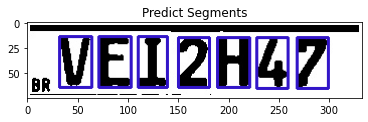

VEI2H47
37.JPG


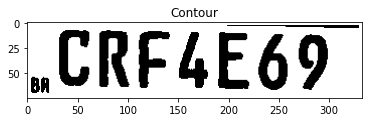

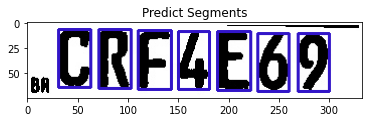

CRF4E69
38.JPG


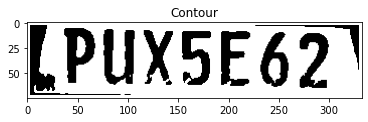

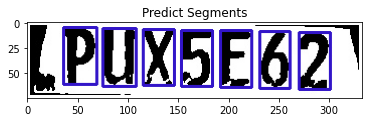

PUX5E62
39.JPG


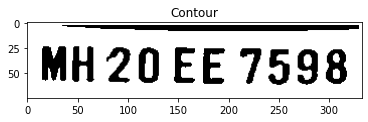

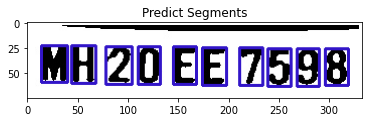

MH20EE7598
4.jpg


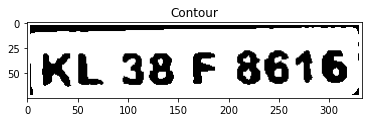

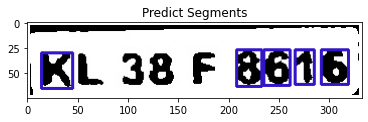

X8616
41.jpeg


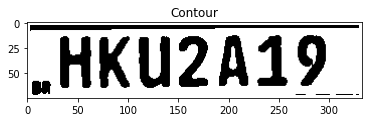

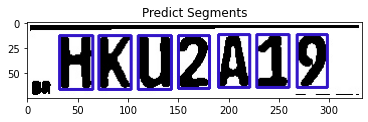

NKU2A19
42.JPG


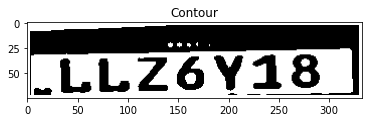

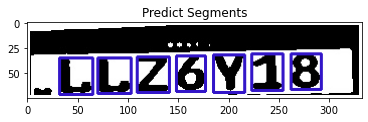

LLZ6Y18
44.JPG


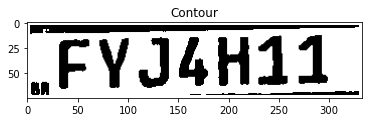

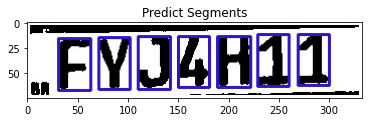

FYJ4H11
46.JPG


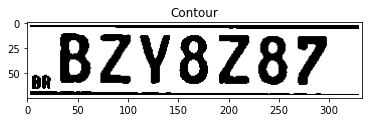

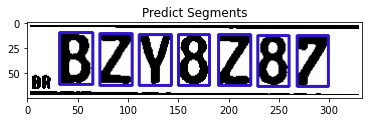

8ZY8Z67
47.JPG


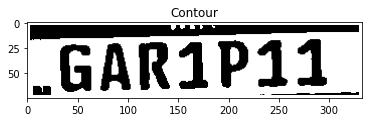

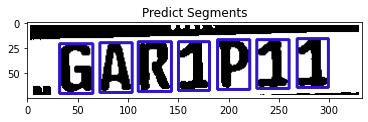

6AR1P11
48.JPG


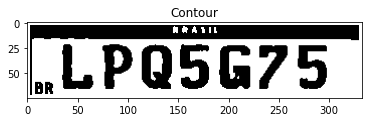

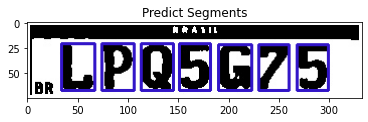

LPQ5G75
49.JPG


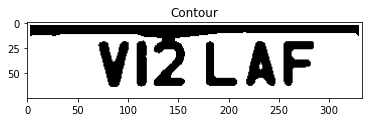

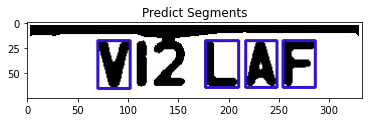

YLAF
5.png


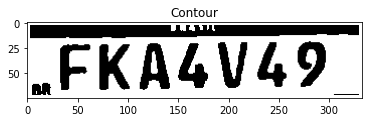

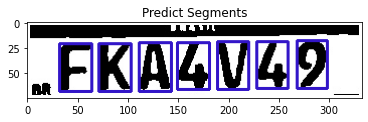

FKA4V49
50.JPG


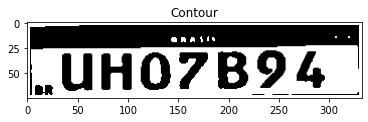

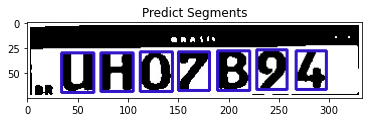

UH07894
51.JPG


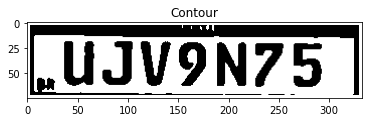

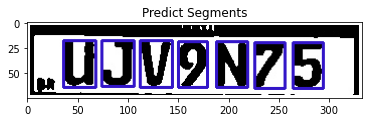

UJV9N75
52.JPG


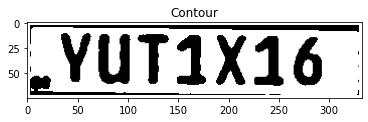

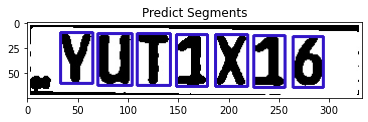

YUT1X16
54.JPG


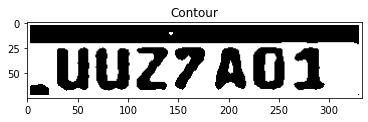

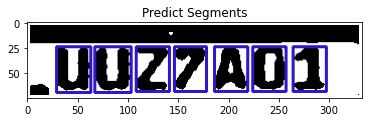

MUZ7A01
55.JPG


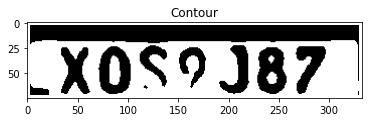

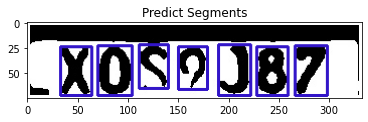

X059J67
56.JPG


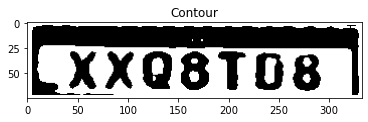

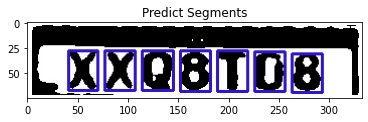

XXQ8T06
57.JPG


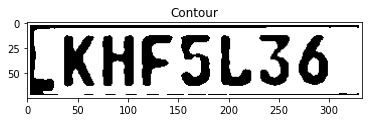

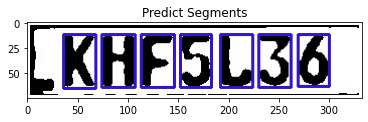

KNF5L56
58.JPG


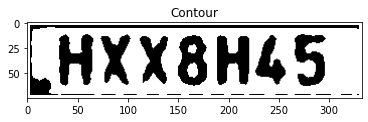

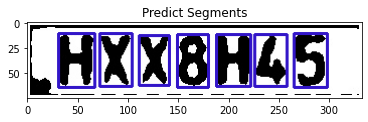

NII8NA5
59.JPG


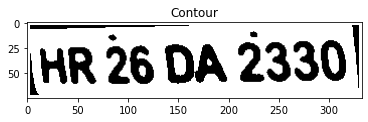

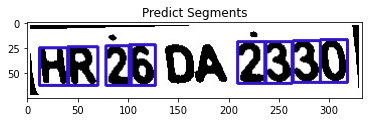

MR262330
6.jpg


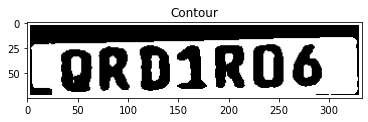

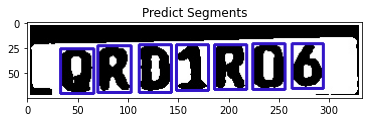

9RD1R06
60.JPG


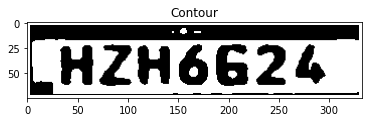

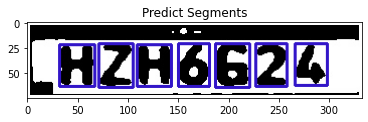

NIN6624
61.JPG


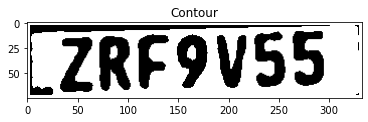

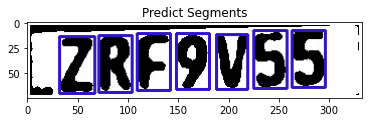

IRF9V55
62.JPG


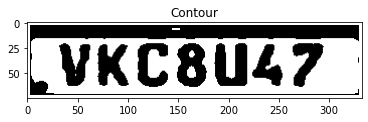

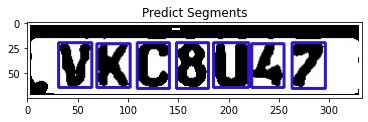

YKC6UA7
63.JPG


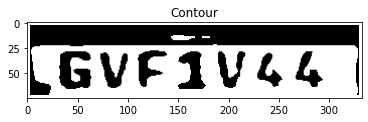

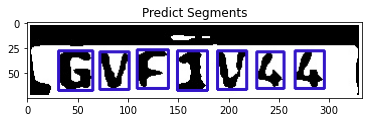

GVF1V44
64.JPG


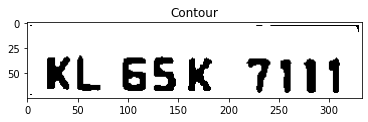

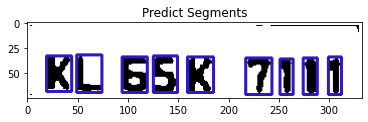

XL65K7JJJ
65.jpeg


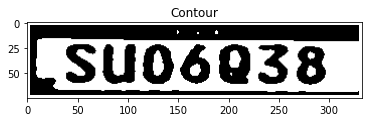

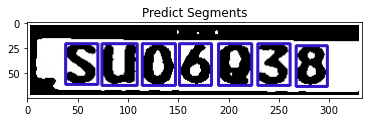

5U06958
66.JPG


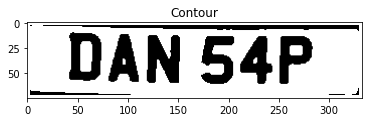

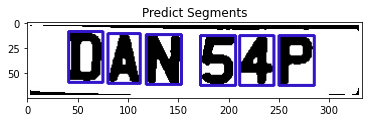

DAN54P
67.png


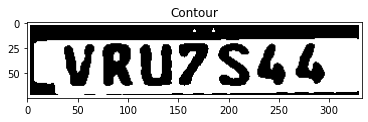

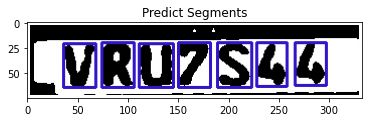

VRU754A
70.JPG


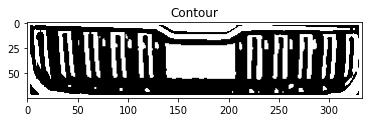

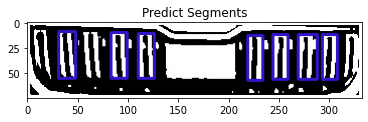

YJJJTWI
71.png


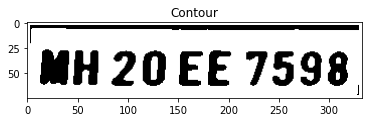

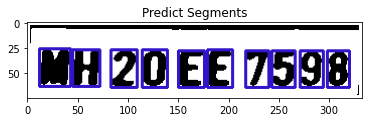

IW20EE7598
72.jpg


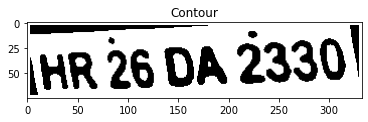

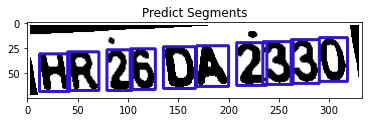

MR26DA2330
73.jpg


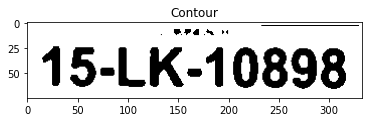

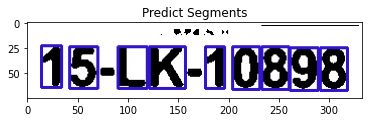

15LK10898
74.jpg


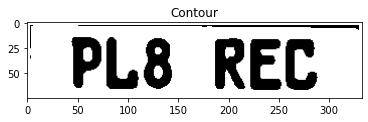

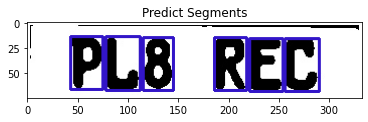

PL6RIC
75.jpg


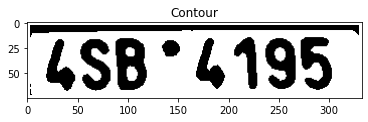

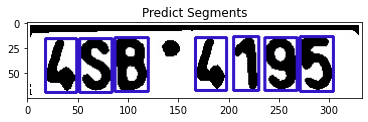

A5BA195
77.jpg


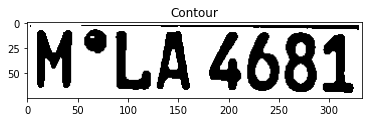

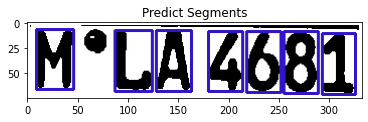

NLA4681
78.jpg


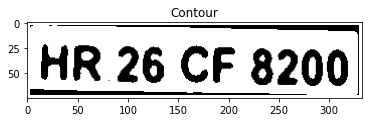

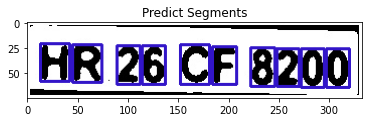

NR26CF8200
79.jpg


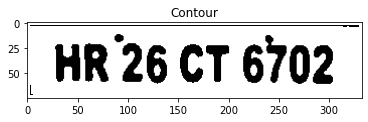

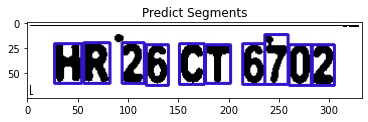

MR26CT6Y02
8.jpg


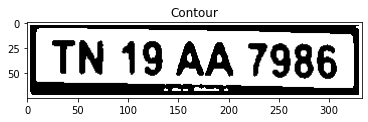

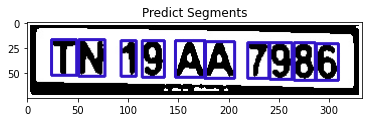

TN19AA7986
80.jpg


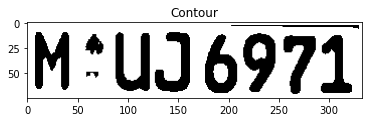

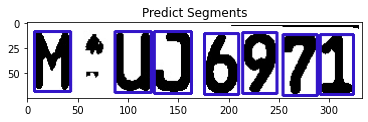

NUJ6971
81.jpg


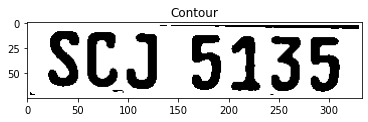

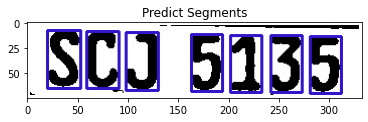

5CJ5155
82.jpg


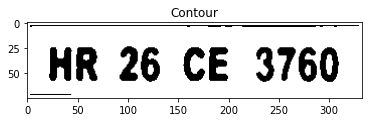

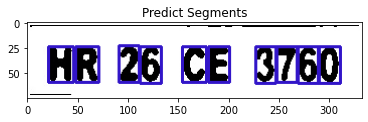

XR26CE3760
83.jpg


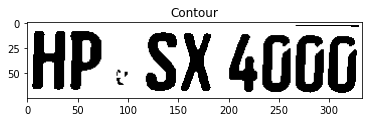

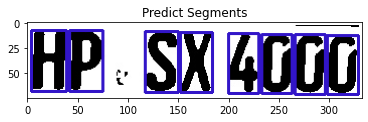

NP5X4000
84.jpg


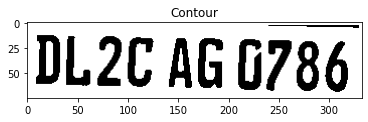

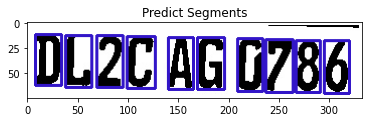

JL2CAGG786
85.png


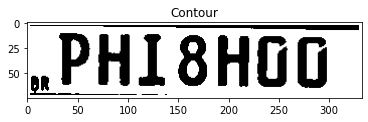

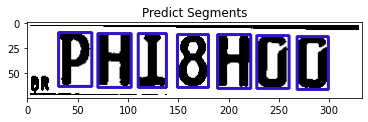

PNI8N00
86.JPG


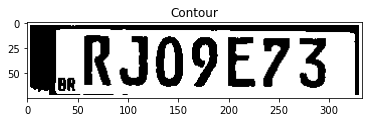

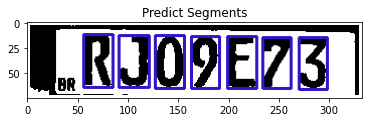

RJ09E75
87.JPG


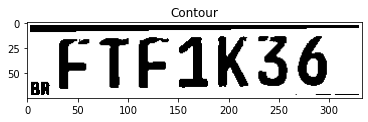

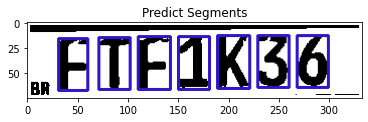

FTF1K56
88.JPG


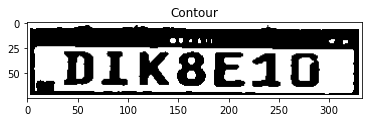

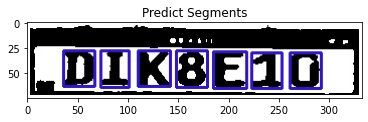

JIK8E10
89.JPG


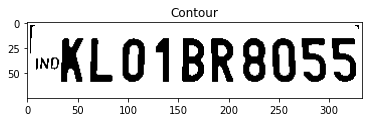

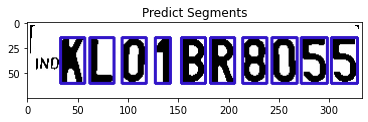

XL018R8055
9.jpg


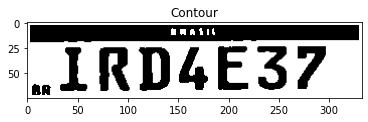

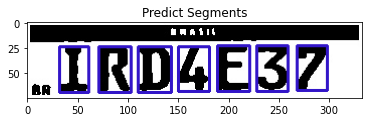

IRJ4E57
90.JPG


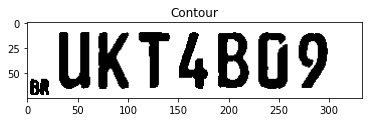

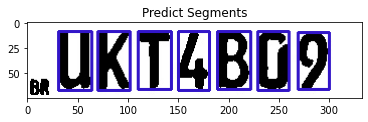

UKT4809
91.JPG


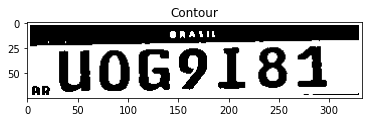

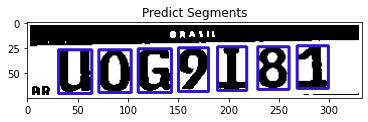

U0G9I81
92.JPG


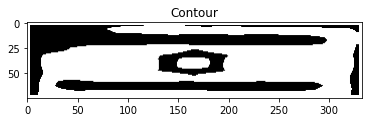


93.png


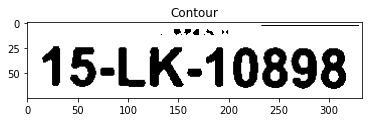

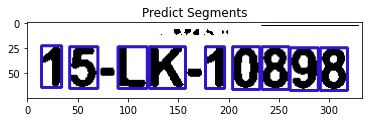

15LK10898
94.png


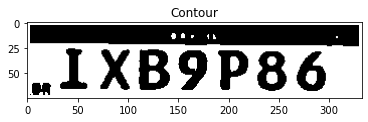

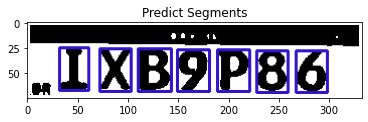

IX89P86
96.JPG


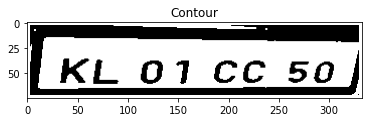


97.png


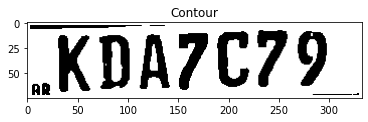

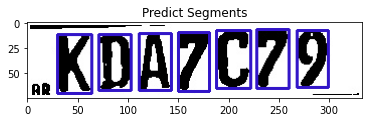

KDA7C79
98.JPG


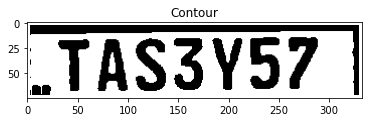

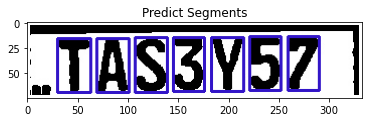

TA55Y57
99.JPG
KL55R2473 IL7BI99 FJR0Y51 J8 IM20EJ0J65 RUJ5L65 ZA60C54 NVN6Y89  ICP7A56 EEY6650 GJJTC JNF5815 DIJ7YXR XFJ2C50 VYP6850 LL68C51 ALR486 NKE0A12 CJN1C22 ZYJ1P05 ZYJ1P05 WH12JC28T3 ACC0G98 5AAJU22 XXX4060 0NC8047 6AJ4PJ2 YP52J07 F6Q5Y90 ZJ17N20  MM14EU3498 VRF4E06 IYZ2Z18 JL7CN56I7 ALR486 J8 CI7K00 CI7K00 A MR26CT6702 JL7CN56I7 DIJ7YXR LLZ6Y18 DIJ7YXR VRF4E06 IW20EE7598 XEGICA2555 6AR1P11 BAV9R95 A 8604L12 49 VJU7V67 VY57A51 PXX7L0J0J  15LK10898 P6MN112 K5L2J01 YUT1X16 KAT3R4 CI7K00 ALR486   XEGICA2555 DIJ7YXR UJV9N75 UH07894 LL68C51 JL7CN56I7 LPQ5G75 6AR1P11 VYP6850 JQJ4558  8ZY8Z67 JNF5815 6AD231 G   6AD231 IN20EJ04 L33 15LK10898 LPL45T5 GJ0JJL0J26 6LJC5 GJW115A1138 P6MN112 15LK10898 IW20EE7598  JQJ4558 G241GH CN0AW000J IYZ2Z18 JET7666 KL16J3636 UKV4L15 VY57A51 VJU7V67 8604L12 BAV9R95 UZ08070 KJE1I58 VEI2H47 CRF4E69 PUX5E62 MH20EE7598 X8616 NKU2A19 LLZ6Y18 FYJ4H11 8ZY8Z67 6AR1P11 LPQ5G75 YLAF FKA4V49 UH07894 UJV9N75 YUT1X16 MUZ7A01 X059J67 XXQ8T06 KNF5L56 NII8NA5 MR262330 

In [26]:
file_list=os.listdir(r"test_dataset/images")
count=0
num=0
plate_list = []
for path in file_list:
    #no=path[:-4]
    #row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    count=show_results(count)
    print(count)
    print(path)
    plate_list.append(count)
for items in plate_list:
    print(items,end=' ')